# Импорт данных

In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class MyDataset(Dataset):
    def __init__(self, x, y, mu=None, sigma=None):
        super().__init__()
        self.x = x
        self.y = y
        self.mu = mu
        self.sigma = sigma

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        item_x = self.x[idx]
        item_y = self.y[idx]
        if self.mu is not None:
            item_x = item_x + torch.randn(len(item_x)) * self.sigma + self.mu
        return item_x, item_y


def import_data(directory_path, file_path, mu, sigma):
    df = pd.read_table(os.path.join(directory_path, file_path), header=None)
    df_numpy = np.float32(df.values)
    tensor_x = torch.from_numpy(df_numpy[:, 4:])
    tensor_y = torch.from_numpy(df_numpy[:, 0:3])
    ds = MyDataset(tensor_x, tensor_y, mu=mu, sigma=sigma)
    return ds, tensor_x, tensor_y

In [2]:
ds_train, tensor_x_train, tensor_y_train = import_data(
    directory_path="",
    file_path="single peak train",
    mu=0,
    sigma=0.01,
)

ds_val, tensor_x_val, tensor_y_val = import_data(
    directory_path="",
    file_path="single peak val",
    mu=None,
    sigma=None,
)

ds_test, tensor_x_test, tensor_y_test = import_data(
    directory_path="",
    file_path="single peak test",
    mu=None,
    sigma=None,
)

## Проверка работы аугментации

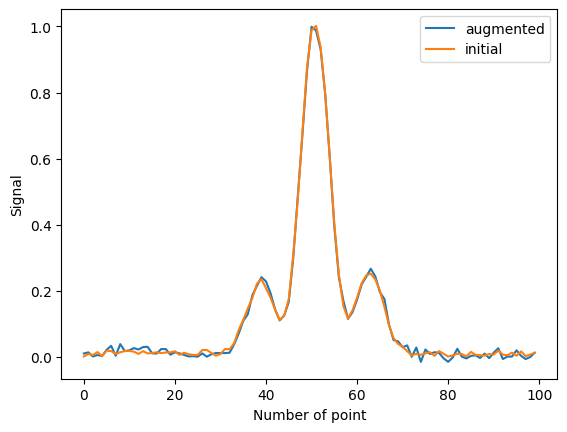

In [3]:
num_samp = 4633
plt.plot(range(len(ds_train.x[num_samp])), ds_train[num_samp][0], label="augmented")
plt.plot(
    range(len(tensor_x_train[num_samp, :])),
    tensor_x_train[num_samp, :],
    label="initial",
)
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of point")
plt.ylabel("Signal")
plt.title("Comparison of initial signal and augmented one")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
plt.show()

# Создание даталоадеров

In [4]:
BATCH_SIZE = 256
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True, num_workers=3)
val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=False, num_workers=3)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=False, num_workers=3)

# Создание модели

In [14]:
from torch import nn


class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(
            nn.Linear(100, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.05),  # 20% probability
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        return self.core(x)
    
model = SimpleModel()

# Создание пайплайна

In [6]:
# !pip install -q lightning
%pip install -q lightning


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [15]:
import lightning as L

from torch import nn
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassAUROC,
)
from torchmetrics.regression import (
    MeanAbsoluteError
)

class LModel(L.LightningModule):
    def __init__(self, model, lr=0.001, gamma=0.99):
        super().__init__()
        self.save_hyperparameters(logger=False)

        # for optimizer and shaduler
        self.lr = lr
        self.gamma = gamma

        # model
        self.model = model
        self.criterion = nn.L1Loss()

        # metrics
        self.metrics = MetricCollection([
            MeanAbsoluteError()
        ])
        self.train_metrics = self.metrics.clone(postfix='/train')
        self.val_metrics = self.metrics.clone(postfix='/val')
        self.test_metrics = self.metrics.clone(postfix='/test')

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss" # only for self.log
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out, y)
        self.log("loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.val_metrics.update(out, y)

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.test_metrics.update(out, y)

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

# Запуск обучения

In [16]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath='best_ckp/',
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MeanAbsoluteError/val",
    filename="model",
    mode="min",
)

L.seed_everything(42)

model = SimpleModel()
pl_model = LModel(model)
trainer = L.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./final_log/"),
    enable_progress_bar = False
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

Seed set to 42
/home/jupyter/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jupyter/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/jupyter/work/resources/TrainTemplateMSUAI/DATA/Single peak/best_ckp exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | SimpleModel      | 1.3 M 
1 | criterion     | L1Loss           | 0     
2 | metrics       | MetricCollection | 0     
3 | train_metrics | MetricCollection | 0     
4 | val_metric

# Загрузка предобученной модели

In [46]:
log_path = '/home/jupyter/datasphere/project/TrainTemplateMSUAI/DATA/Single peak/best_ckp/'
ckpt_path = f"{log_path}model-v1.ckpt"
checkpoint = torch.load(ckpt_path)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict = {}
for key in checkpoint["state_dict"].keys():
    key_new = key.lstrip("model.")
    state_dict[key_new] = checkpoint["state_dict"][key]

model = SimpleModel()

model.load_state_dict(state_dict)

model.eval()

/tmp/ipykernel_7792/586285977.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Checkpoint has been loaded from /home/jupyter/datasphere/project/TrainTemplateMSUAI/DATA/Single peak/best_ckp/model-v1.ckpt
Best model has been saved on the 62 epoch


SimpleModel(
  (core): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=256, bias=True)
    (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.05, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=3, bias=True)
  )
)

# Тестирование 1

In [17]:
trainer.test(model=pl_model, dataloaders=test_loader, ckpt_path="best")

Restoring states from the checkpoint path at /home/jupyter/work/resources/TrainTemplateMSUAI/DATA/Single peak/best_ckp/model-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/jupyter/work/resources/TrainTemplateMSUAI/DATA/Single peak/best_ckp/model-v1.ckpt
/home/jupyter/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MeanAbsoluteError/test   │   0.009603740647435188    │
└───────────────────────────┴───────────────────────────┘

[{'MeanAbsoluteError/test': 0.009603740647435188}]

## Проверка значений

In [ ]:
model.eval()
sample_num = 436
tensor_x_test[:,sample_num].shape
print(tensor_y_test[None,:,sample_num])
print(model(tensor_x_test[None, :,sample_num]))

tensor([[0.9363, 0.1525, 0.8230]])
tensor([[0.9517, 0.1652, 0.8816]], grad_fn=<AddmmBackward0>)


# Тестирование 2

## Визуальное сравнение значений 

  0%|          | 0/2000 [00:00<?, ?it/s]

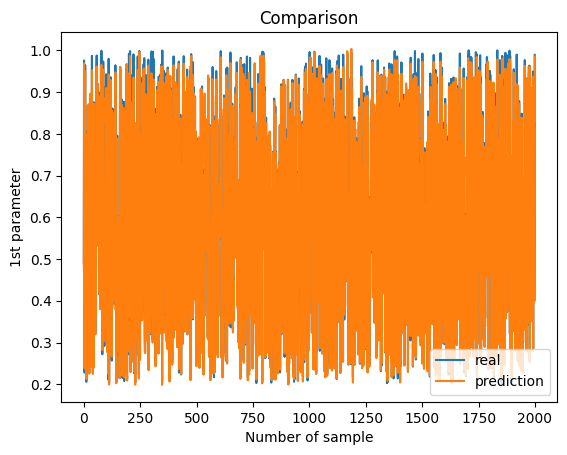

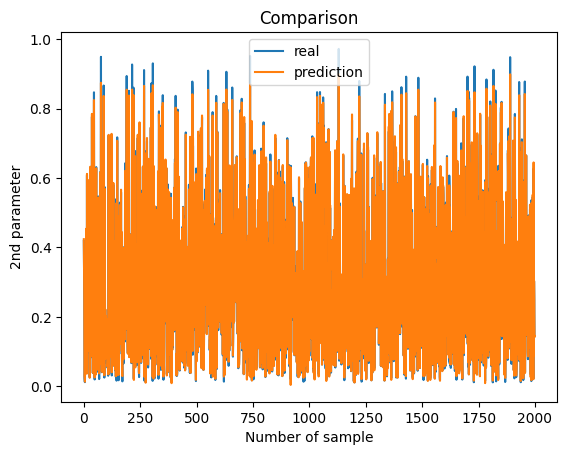

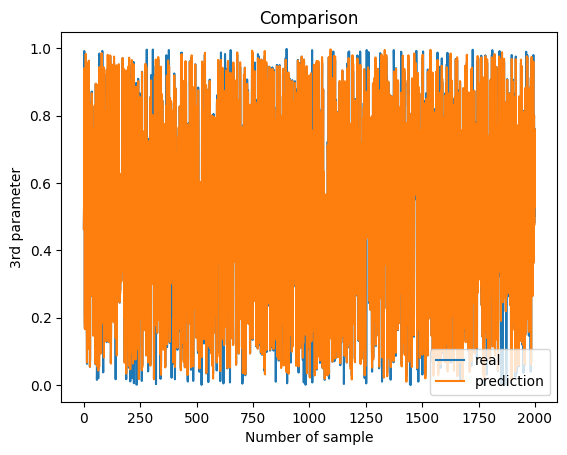

In [18]:
model.eval()
num_samples = tensor_x_test.shape[0]
pred1 = np.zeros(num_samples)
pred2 = np.zeros(num_samples)
pred3 = np.zeros(num_samples)
pred4 = np.zeros(num_samples)
pred5 = np.zeros(num_samples)
pred6 = np.zeros(num_samples)
for i in tqdm(range(num_samples)):
    pred = model(tensor_x_test[None, i, :])
    pred1[i] = pred[0, 0]
    pred2[i] = pred[0, 1]
    pred3[i] = pred[0, 2]

plt.plot(range(num_samples), tensor_y_test[:, 0], label="real")
plt.plot(range(num_samples), pred1, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("1st parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
plt.show()

plt.plot(range(num_samples), tensor_y_test[:, 1], label="real")
plt.plot(range(num_samples), pred2, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("2nd parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
plt.show()

plt.plot(range(num_samples), tensor_y_test[:, 2], label="real")
plt.plot(range(num_samples), pred3, label="prediction")
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Number of sample")
plt.ylabel("3rd parameter")
plt.title("Comparison")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
# To load the display window
# xlim((0,100))
plt.show()

## Гистограммы MAE для значений

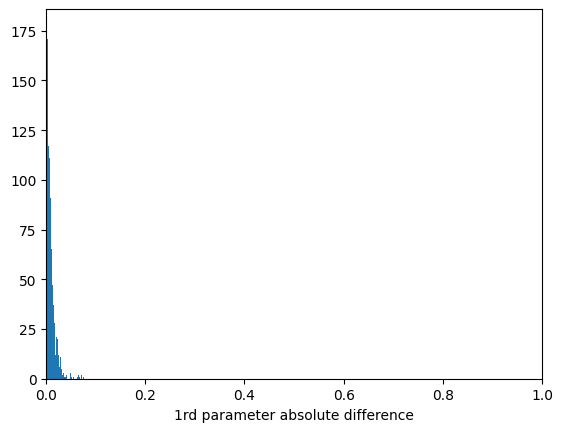

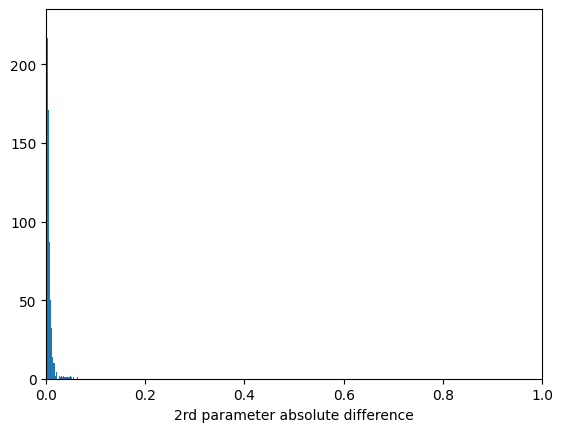

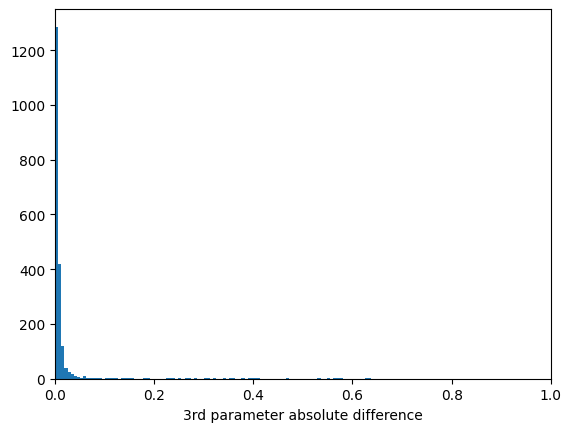

In [19]:
dy1 = abs(tensor_y_test[:,0] - pred1)
plt.hist(bins=100, x=dy1)
plt.xlabel("1rd parameter absolute difference")
plt.xlim((0,1))
plt.show()

dy2 = abs(tensor_y_test[:,1] - pred2)
plt.hist(bins=100, x=dy2)
plt.xlabel("2rd parameter absolute difference")
plt.xlim((0,1))
plt.show()

dy3 = abs(tensor_y_test[:,2] - pred3)
plt.hist(bins=100, x=dy3)
plt.xlabel("3rd parameter absolute difference")
plt.xlim((0,1))
plt.show()

# Выгрузка результатов

## Параметр 1

### Реальный

In [20]:
for i in range(tensor_y_test.numpy().shape[0]):
    print(tensor_y_test.numpy()[i,0])

0.490672
0.975774
0.294632
0.227962
0.449572
0.796585
0.964363
0.315932
0.386343
0.56229
0.783771
0.205776
0.287897
0.527378
0.787578
0.806667
0.681413
0.646529
0.86818
0.596978
0.850002
0.759551
0.856958
0.41264
0.226377
0.403024
0.648342
0.314412
0.319392
0.894136
0.723964
0.608004
0.243225
0.537134
0.442779
0.685745
0.986728
0.642658
0.544435
0.662872
0.228493
0.649151
0.290397
0.356026
0.242081
0.875535
0.682288
0.715239
0.595199
0.75324
0.626722
0.320322
0.50402
0.382238
0.479803
0.741521
0.94576
0.987526
0.859256
0.720387
0.920677
0.582103
0.553497
0.642345
0.810903
0.537516
0.898545
0.888665
0.543252
0.475147
0.413888
0.510866
0.522636
0.385784
0.856136
0.523428
0.978878
0.480884
0.999011
0.766204
0.968344
0.741564
0.271808
0.357707
0.598027
0.828813
0.973373
0.847248
0.912304
0.740868
0.43997
0.291525
0.574219
0.673103
0.472706
0.400355
0.499233
0.663359
0.334299
0.942597
0.848536
0.908895
0.872128
0.27814
0.783902
0.321222
0.535541
0.303194
0.211145
0.439344
0.979478
0.586811


### Восстановленный

In [21]:
for i in range(len(pred1)):
    print(pred1[i])

0.4825441241264343
0.9687044620513916
0.28773611783981323
0.23793575167655945
0.43808233737945557
0.7903875708580017
0.9489774703979492
0.3184048533439636
0.3868759870529175
0.5818074345588684
0.7850143909454346
0.21264317631721497
0.2934775650501251
0.5208472609519958
0.7840826511383057
0.7981328368186951
0.6784766316413879
0.6417032480239868
0.8659303784370422
0.6032054424285889
0.8677583336830139
0.753017783164978
0.8709787726402283
0.40557873249053955
0.225478857755661
0.40148741006851196
0.6066960692405701
0.3175002932548523
0.32059037685394287
0.8961185216903687
0.7093448638916016
0.5923519134521484
0.2416992038488388
0.5367377400398254
0.44130945205688477
0.6816189289093018
0.9519178867340088
0.651093602180481
0.5460589528083801
0.6631026268005371
0.22457756102085114
0.656370997428894
0.29394951462745667
0.355530321598053
0.23988136649131775
0.8716877102851868
0.6728601455688477
0.7170377373695374
0.5741286873817444
0.7468245029449463
0.6098644137382507
0.3193497061729431
0.5004

## Параметр 2

### Реальный

In [22]:
for i in range(tensor_y_test.numpy().shape[0]):
    print(tensor_y_test.numpy()[i,1])

0.418928
0.336393
0.244746
0.023922
0.013623
0.01179
0.170142
0.151128
0.080436
0.07683
0.452266
0.152179
0.280607
0.041837
0.608002
0.155078
0.545878
0.318308
0.136909
0.457218
0.590487
0.433046
0.521265
0.09793
0.181647
0.108659
0.0263
0.190266
0.181535
0.630109
0.495414
0.507061
0.192411
0.224623
0.336501
0.303059
0.776459
0.381091
0.082842
0.490275
0.038272
0.260665
0.129977
0.345384
0.212071
0.846741
0.302704
0.393309
0.019635
0.347824
0.261406
0.17447
0.302575
0.035888
0.461293
0.631334
0.114108
0.146049
0.309506
0.54613
0.379381
0.071256
0.385904
0.537547
0.136358
0.040283
0.159411
0.546955
0.02082
0.435402
0.105007
0.075489
0.285906
0.377272
0.617674
0.229307
0.948937
0.458861
0.279792
0.158325
0.040344
0.661057
0.246968
0.044053
0.438553
0.703492
0.067212
0.098533
0.866256
0.656935
0.319541
0.025079
0.453516
0.573433
0.168023
0.220818
0.06774
0.178742
0.198821
0.113505
0.123587
0.122684
0.114832
0.186747
0.108967
0.053492
0.064241
0.075002
0.03031
0.40672
0.72233
0.397792
0.03

### Восстановленный

In [23]:
for i in range(len(pred2)):
    print(pred2[i])

0.42374032735824585
0.34553512930870056
0.25276389718055725
0.02826172113418579
0.02583758533000946
0.013189420104026794
0.17134153842926025
0.15261438488960266
0.08482047915458679
0.09775261580944061
0.4536595642566681
0.16184695065021515
0.28245872259140015
0.03619316965341568
0.6117445230484009
0.1572979837656021
0.5427877902984619
0.31587618589401245
0.13989004492759705
0.4534558057785034
0.593700110912323
0.4379034638404846
0.5284476280212402
0.10316191613674164
0.1850026547908783
0.11544786393642426
0.024355515837669373
0.2020377218723297
0.18875885009765625
0.6325371265411377
0.4844088554382324
0.5178091526031494
0.1972542405128479
0.22940662503242493
0.3385544419288635
0.30510398745536804
0.7846214771270752
0.383007675409317
0.08500063419342041
0.4895072281360626
0.03861483186483383
0.25962162017822266
0.13171125948429108
0.3336702883243561
0.2130410075187683
0.8243936896324158
0.3009377121925354
0.3970381021499634
0.025177188217639923
0.34929603338241577
0.26408252120018005
0.

## Параметр 3

### Реальный

In [24]:
for i in range(tensor_y_test.numpy().shape[0]):
    print(tensor_y_test.numpy()[i,2])

0.466003
0.528522
0.992444
0.953009
0.213617
0.167394
0.86936
0.306615
0.963195
0.949319
0.780518
0.709022
0.789905
0.213713
0.062885
0.307017
0.952432
0.357578
0.598387
0.660405
0.739733
0.109509
0.950381
0.17839
0.665951
0.248601
0.74834
0.054099
0.082628
0.833552
0.320917
0.264093
0.390008
0.839566
0.318127
0.871939
0.779837
0.47371
0.497145
0.616152
0.47854
0.667516
0.152104
0.634459
0.723039
0.76272
0.395036
0.258871
0.82716
0.462728
0.381337
0.716968
0.061661
0.894802
0.531967
0.095657
0.099211
0.569638
0.015208
0.061566
0.88469
0.113487
0.499727
0.14643
0.019715
0.368022
0.742661
0.445943
0.08822
0.984946
0.508536
0.823512
0.897501
0.278193
0.205188
0.803742
0.09763
0.942316
0.187948
0.978134
0.6216
0.758745
0.99272
0.792061
0.781495
0.195702
0.03751
0.771463
0.935896
0.085256
0.817819
0.92355
0.514521
0.660827
0.567317
0.396149
0.141466
0.652687
0.798813
0.815737
0.634783
0.127441
0.869033
0.927197
0.283004
0.563917
0.941632
0.303617
0.375345
0.21433
0.447956
0.149913
0.874911


### Восстановленный

In [25]:
for i in range(len(pred3)):
    print(pred3[i])

0.4630005955696106
0.5409032106399536
0.8532217741012573
0.942202091217041
0.18252678215503693
0.16602535545825958
0.8647204041481018
0.3045509159564972
0.981596827507019
0.983916163444519
0.7752804160118103
0.7105185985565186
0.7870369553565979
0.1969999372959137
0.06701309978961945
0.31732621788978577
0.9569488763809204
0.3535188138484955
0.6040502786636353
0.6664751768112183
0.7393912076950073
0.10709023475646973
0.9637077450752258
0.17726676166057587
0.6629039645195007
0.2538515031337738
0.732324481010437
0.05415602773427963
0.08569832146167755
0.8329587578773499
0.32651394605636597
0.2646888792514801
0.3867655396461487
0.8360215425491333
0.31795060634613037
0.8670893907546997
0.7785524129867554
0.4861271381378174
0.5143839120864868
0.6143607497215271
0.4774225950241089
0.6646053791046143
0.14629942178726196
0.6294387578964233
0.7183611989021301
0.762264609336853
0.3964223861694336
0.25431257486343384
0.8307073712348938
0.46198344230651855
0.3750074803829193
0.7182396650314331
0.06

# Тестирование на экспериментальных данных

In [43]:
df_exp = pd.read_table('SHG signal.txt', header=None)
df_exp_numpy = np.float32(df_exp.values)
tensor_x_exp = torch.from_numpy(df_exp_numpy).squeeze()

predExp = model(tensor_x_exp[None,:])
predExp